In [1]:
import orchest
import pandas as pd
import time
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
data = orchest.get_inputs()

In [3]:
clarify_data = data['clarify_data']
energy_consumption_dfs = clarify_data['energy_consumption']
temperature_df = clarify_data['temperature']

In [4]:
energy_consumption_dfs['daily']['Blomsterbyen barnehage']

,Fastkraft,Fjernvarme,Totalt
2018-01-01 00:00:00+00:00,167.0,342.0,509.0
2018-01-02 00:00:00+00:00,306.0,443.0,749.0
2018-01-03 00:00:00+00:00,317.0,761.0,1078.0
2018-01-04 00:00:00+00:00,307.0,457.0,764.0
2018-01-05 00:00:00+00:00,322.0,609.0,931.0
...,...,...,...
2019-12-28 00:00:00+00:00,176.0,256.0,432.0
2019-12-29 00:00:00+00:00,163.0,198.0,361.0
2019-12-30 00:00:00+00:00,280.0,418.0,698.0
2019-12-31 00:00:00+00:00,178.0,317.0,495.0


In [5]:
temperature_df['hourly']

,Voll TAN,Voll TAX
2018-01-01 00:00:00+00:00,-0.2,1.0
2018-01-01 01:00:00+00:00,0.7,1.2
2018-01-01 02:00:00+00:00,1.1,1.5
2018-01-01 03:00:00+00:00,0.6,1.4
2018-01-01 04:00:00+00:00,0.9,1.3
...,...,...
2020-01-01 19:00:00+00:00,7.5,7.9
2020-01-01 20:00:00+00:00,7.0,7.5
2020-01-01 21:00:00+00:00,6.9,7.1
2020-01-01 22:00:00+00:00,6.7,7.0


In [6]:
def linear_interpolation(x, x0, y0, x1, y1):
    slope = (y1 - y0) / (x1 - x0)
    return y0 + (x - x0) * slope

class et_curve():
    def __init__(self, dx, dy):
        self.dx = dx
        self.dy = dy

    def expected(self, temperature):
        if temperature < self.dx[0]:
            # print(f'{temperature} is below range, lowest point is ({self.dx[0]}, {self.dy[0]})')
            # TODO improve this prediction
            return linear_interpolation(temperature, self.dx[0], self.dy[0], self.dx[1], self.dy[1])
        if temperature > self.dx[-1]:
            # print(f'{temperature} is above range, highest point is ({self.dx[-1]}, {self.dy[-1]})')
            return self.dy[-1]

        for i in range(len(self.dx) - 1):
            if self.dx[i] <= temperature and temperature <= self.dx[i+1]:
                return linear_interpolation(temperature, self.dx[i], self.dy[i], self.dx[i+1], self.dy[i+1])
    
    def get_expected_series(self, temperature_series):
        return temperature_series.apply(self.expected)
    
    def get_proportial_series(self, energy_series, temperature_series):
        expected_series = self.get_expected_series(temperature_series)
        return energy_series / expected_series

    def get_anomolies_series(self, energy_series, temperature_series, threshold):
        expected_series = self.get_expected_series(temperature_series)
        mask = energy_series / expected_series >= (threshold + 1)
        return energy_series[mask]

In [7]:
def generate_et_curve(energy_consumption_series: pd.Series, temperature_series: pd.Series, points_per_segment, plot: bool = False):

    # ensure that we match values for energy and temp, and that there are no nan values.
    energy_consumption_series.rename('energy', inplace=True)
    temperature_series.rename('temperature', inplace=True)
    df = pd.concat((energy_consumption_series, temperature_series), axis=1, ignore_index=False)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.sort_values(by='temperature', inplace=True)

    number_of_points = df.shape[0]

    X = df['temperature'].values.reshape(number_of_points, 1)
    y = df['energy'].values.reshape(number_of_points, 1)

    dx = []
    dy = []

    for i in range(0, number_of_points + 1, points_per_segment):
        n = min(points_per_segment, number_of_points - i)

        X_seg = X[i:i+n, :]
        y_seg = y[i:i+n, :]

        model = LinearRegression()
        model.fit(X_seg, y_seg)

        if i == 0:
            X_first = X_seg[0].reshape(1,1)
            y_first = model.predict(X_first)
            dx.append(X_first[0,0])
            dy.append(y_first[0,0])

        X_middle = X_seg[n//2].reshape(1,1)
        y_middle = model.predict(X_middle)
        dx.append(X_middle[0,0])
        dy.append(y_middle[0,0])

        if i >= number_of_points - points_per_segment:
            X_last = X_seg[-1].reshape(1,1)
            y_last = model.predict(X_last)
            dx.append(X_last[0,0])
            dy.append(y_last[0,0])

    if plot:
        plt.plot(dx, dy, color='blue', linewidth=3)
        plt.plot(dx, [y*1.1 for y in dy], color='red', linewidth=3)
        plt.plot(dx, [y*0.9 for y in dy], color='red', linewidth=3)
        plt.scatter(X, y, color='black')
        plt.show()

    return et_curve(dx, dy)


In [8]:
energy_consumption_day_of_week_dfs = {}
for building_name in energy_consumption_dfs['daily'].keys():
    day_of_week_dict = {}
    energy_consumption_day_of_week_dfs[building_name] = day_of_week_dict
    for i in range(7):
        day_of_week_dict[i] = energy_consumption_dfs['daily'][building_name].iloc[energy_consumption_dfs['daily'][building_name].index.dayofweek == i]


Angelltrøa barnehage
Monday


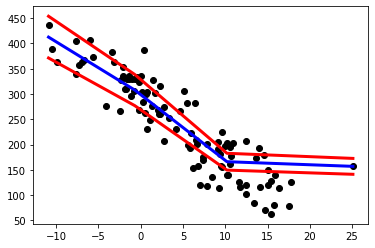

Tuesday


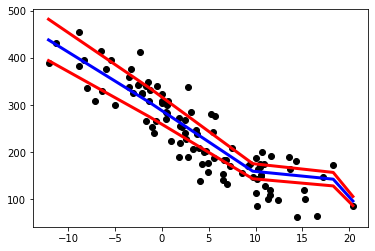

Wednesday


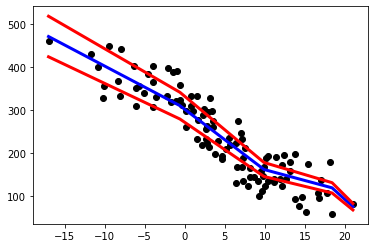

Thursday


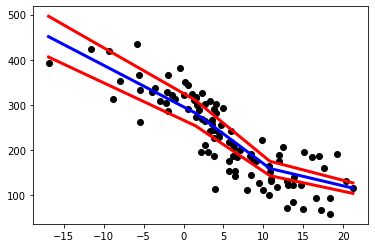

Friday


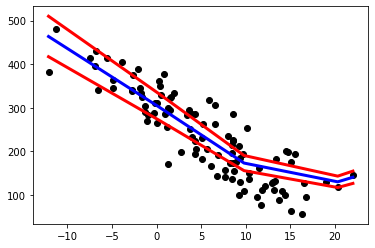

Saturday


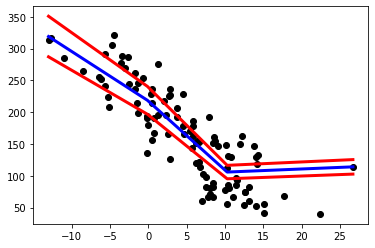

Sunday


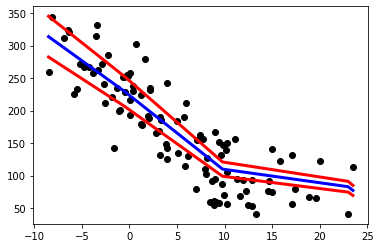

Blomsterbyen barnehage
Monday


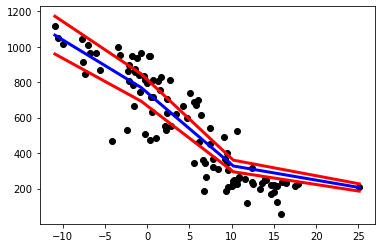

Tuesday


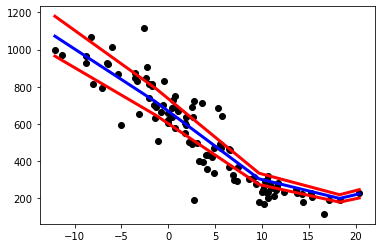

Wednesday


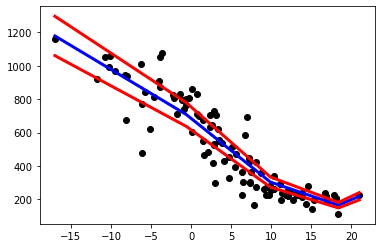

Thursday


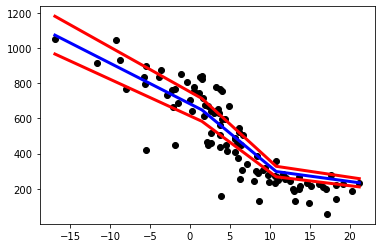

Friday


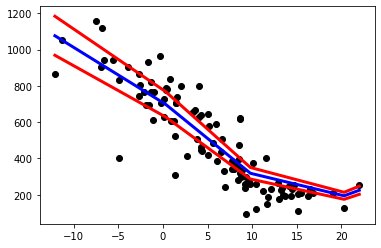

Saturday


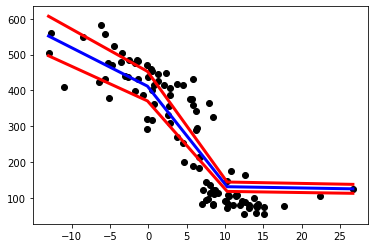

Sunday


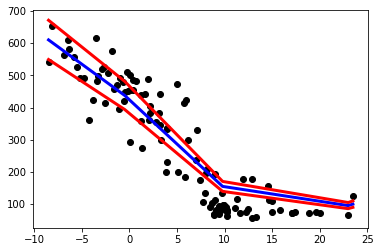

Brannhaugen Barnehage
Monday


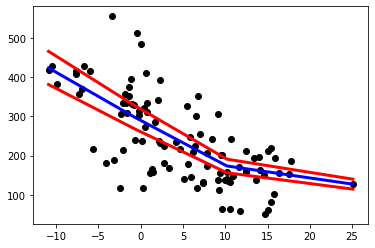

Tuesday


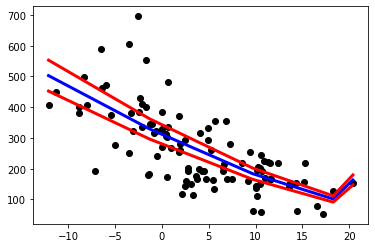

Wednesday


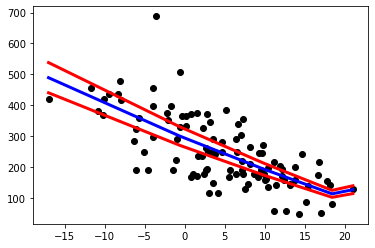

Thursday


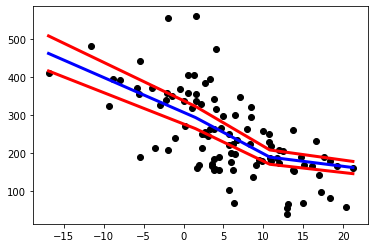

Friday


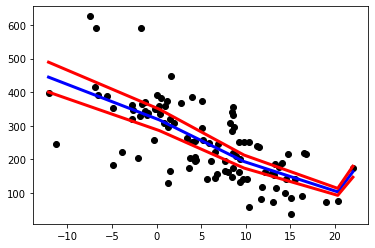

Saturday


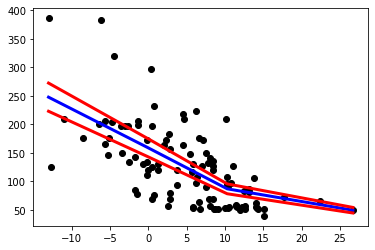

Sunday


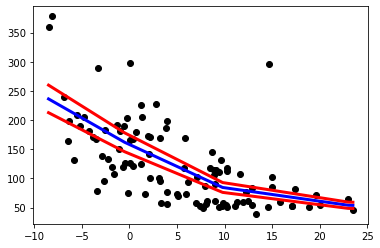

Breidablikk barnehage


In [9]:
week_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

i = 0
et_curves_day_of_week = {}
for name, day_of_week_dfs in energy_consumption_day_of_week_dfs.items():

    i += 1
    num_to_plot = 4
    if i <= num_to_plot:
        print(name)

    et_curves_day_of_week[name] = {}

    for day_of_week, consumption_df in day_of_week_dfs.items():
        if i < num_to_plot:
            print(week_days[day_of_week])
        building_et_curve = generate_et_curve(consumption_df['Totalt'], temperature_df['hourly']['Voll TAN'], 50, i < num_to_plot)
        et_curves_day_of_week[name][day_of_week] = building_et_curve


In [10]:
et_curves = {
    'day_of_week_et_curves': et_curves_day_of_week
}

In [11]:
print('outputting generated et curves...')
orchest.output(et_curves, name='et_curves')
print('success')

outputting generated et curves...
success
